# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

## Data preparation

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [2]:
# Importing tools and modules for data preperation
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import splitfolders

In [3]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading kaggle dataset
# Cell output cleared as only contains data download progress
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Creating parent folder directory for data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

In [5]:
# Splitting data into train, test, and validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15,0.15))

Copying files: 10560 files [00:01, 6302.19 files/s]


In [6]:
# Creating directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [7]:
# Variable to rescale data as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [76]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=1000,
                                              seed=42
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=500,
                                             seed=42
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=500,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [77]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [10]:
# Add some data exploration stuff

In [167]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

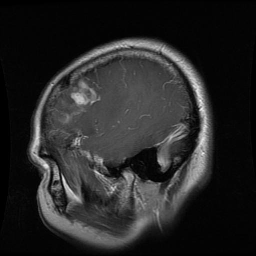

In [11]:
array_to_img(train_images[2])

# Modeling

In [12]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [13]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [14]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [15]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### Base CNN Model

In [78]:
base_cnn = Sequential()

In [79]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dropout(0.5))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [80]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [81]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=100,
                                validation_data=(val_images, val_labels))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.3212 - loss: 2.2492 - val_accuracy: 0.4800 - val_loss: 1.1552
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5658 - loss: 1.0714 - val_accuracy: 0.6400 - val_loss: 0.8263
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6659 - loss: 0.8011 - val_accuracy: 0.6840 - val_loss: 0.7240
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6880 - loss: 0.6820 - val_accuracy: 0.7140 - val_loss: 0.7048
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7699 - loss: 0.5446 - val_accuracy: 0.7120 - val_loss: 0.6547
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8336 - loss: 0.4540 - val_accuracy: 0.7500 - val_loss: 0.6022
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8466 - loss: 0.3699 - val_accuracy: 0.7940 - val_loss: 0.5811
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8944 - loss: 0.2841 - val_accuracy: 0.8000 - 

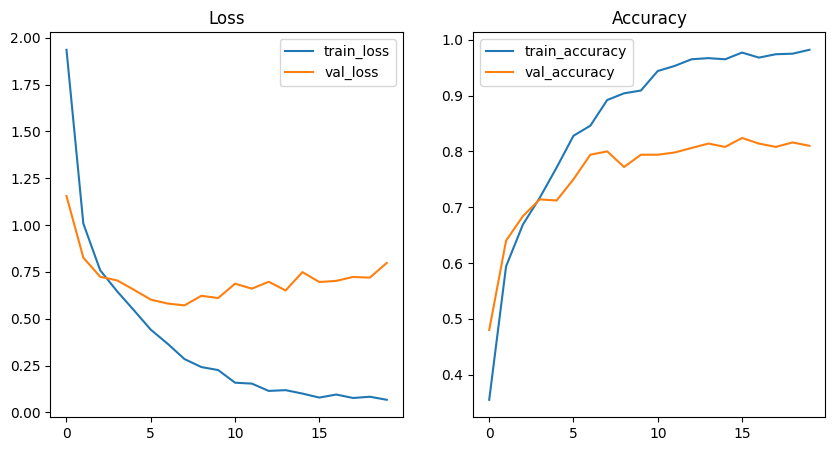

In [82]:
plot_results([base_cnn_results])

In [83]:
model_evaluation(base_cnn, data_dict)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7894 - loss: 0.8501
Train Data, Loss: 0.8353, Accuracy: 0.7880
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7943 - loss: 0.8359
Val Data, Loss: 0.7979, Accuracy: 0.8100


### Base DenseNet Model

In [84]:
dn_base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [85]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [86]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [87]:
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=20,
                                          batch_size=100,
                                          validation_data=(val_images, val_labels))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5373 - loss: 1.1737 - val_accuracy: 0.5440 - val_loss: 1.1415
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.8214 - loss: 0.4487 - val_accuracy: 0.3940 - val_loss: 1.3588
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9059 - loss: 0.2911 - val_accuracy: 0.2740 - val_loss: 8.1474
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9379 - loss: 0.1846 - val_accuracy: 0.3020 - val_loss: 8.3432
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9340 - loss: 0.1839 - val_accuracy: 0.4100 - val_loss: 12.1649
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9664 - loss: 0.1247 - val_accuracy: 0.5080 - val_loss: 6.4337
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9767 - loss: 0.0911 - val_accuracy: 0.6020 - val_loss: 3.4903
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9570 - loss: 0.1534 - val_accuracy: 0.

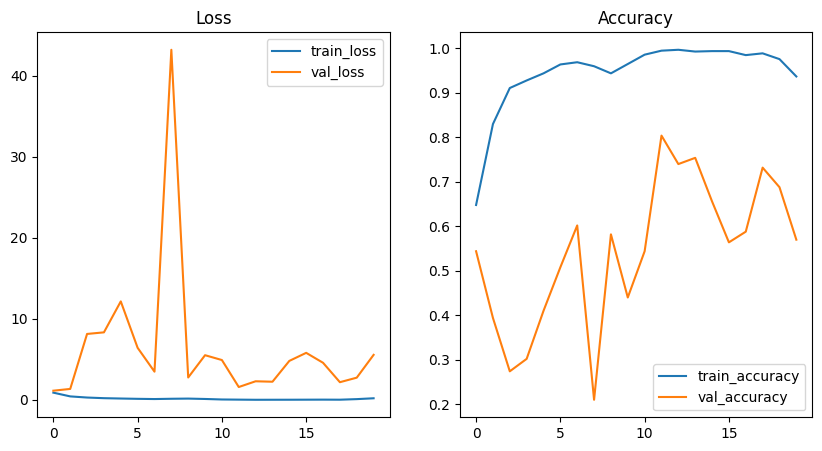

In [88]:
plot_results([base_densenet_results])

In [89]:
model_evaluation(base_densenet, data_dict)

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - accuracy: 0.6010 - loss: 5.5963
Train Data, Loss: 6.0056, Accuracy: 0.5700
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5858 - loss: 5.1543
Val Data, Loss: 5.5653, Accuracy: 0.5700


### Base ResNet Model

In [90]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [91]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [92]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [93]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=100,
                                      validation_data=(val_images, val_labels))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 719ms/step - accuracy: 0.6009 - loss: 1.1129 - val_accuracy: 0.1660 - val_loss: 5.9876
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.7394 - loss: 0.7284 - val_accuracy: 0.2100 - val_loss: 771.8542
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.8662 - loss: 0.3788 - val_accuracy: 0.3680 - val_loss: 3391.8020
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9110 - loss: 0.2624 - val_accuracy: 0.3680 - val_loss: 205.0931
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9621 - loss: 0.1382 - val_accuracy: 0.2100 - val_loss: 7.7917
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9317 - loss: 0.2181 - val_accuracy: 0.1660 - val_loss: 28.1022
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9471 - loss: 0.1507 - val_accuracy: 0.3680 - val_loss: 30.4037
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9592 - loss: 0.1228 - val_ac

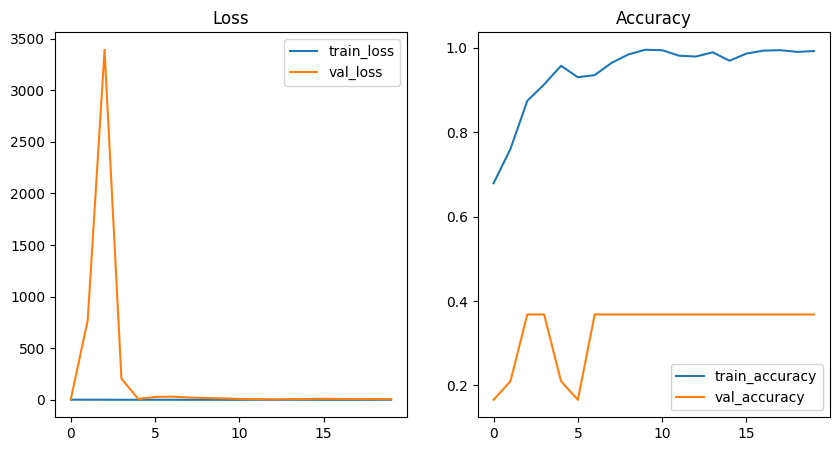

In [94]:
plot_results([base_resnet_results])

In [95]:
model_evaluation(base_resnet, data_dict)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.3599 - loss: 5.6469
Train Data, Loss: 5.8632, Accuracy: 0.3320
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3915 - loss: 5.3150
Val Data, Loss: 5.6557, Accuracy: 0.3680


## CNN Model

In [173]:
cnn_model = Sequential()

cnn_model.add(layers.Input(shape=(256, 256, 3)))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

cnn_model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.4)))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(l2=0.3)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(10, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model_results = cnn_model.fit(train_images, train_labels,
                                  epochs=50,
                                  batch_size=250,
                                  validation_data=(val_images, val_labels))

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2424 - loss: 40.0538 - val_accuracy: 0.4240 - val_loss: 36.0161
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3096 - loss: 35.1424 - val_accuracy: 0.3680 - val_loss: 32.1932
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3219 - loss: 31.3729 - val_accuracy: 0.3680 - val_loss: 28.6785
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3627 - loss: 27.9192 - val_accuracy: 0.4740 - val_loss: 25.5152
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.3744 - loss: 24.8186 - val_accuracy: 0.3880 - val_loss: 22.7160
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.3995 - loss: 22.0835 - val_accuracy: 0.4200 - val_loss: 20.2523
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.4173 - loss: 19.6682 - val_accuracy: 0.3700 - val_loss: 18.1102
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.4155 - loss: 17.5874 - val_accuracy: 0.402

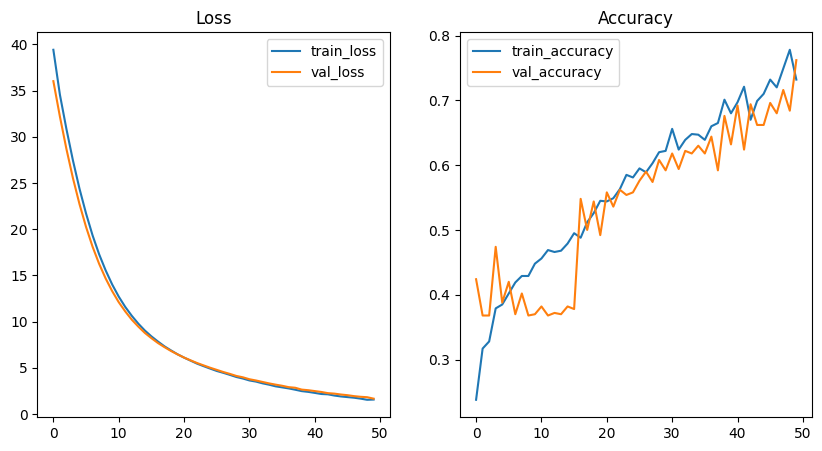

In [174]:
plot_results([cnn_model_results])

In [175]:
model_evaluation(cnn_model, data_dict)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7731 - loss: 1.6820
Train Data, Loss: 1.6739, Accuracy: 0.7720
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7733 - loss: 1.6684
Val Data, Loss: 1.6766, Accuracy: 0.7620


In [177]:
# Getting test data pedictions
test_img_pred = cnn_model.predict(test_images)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_true_labels, test_img_pred_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       183
           1       0.59      0.47      0.52       115
           2       0.93      0.84      0.88        81
           3       0.90      0.88      0.89       121

    accuracy                           0.78       500
   macro avg       0.79      0.77      0.77       500
weighted avg       0.77      0.78      0.77       500



# Evaluation

# Limitations

# Next Steps